The code has been implemented in Keras. For performing model extraction attacks and defense we use IBM Art.
<br>
title = Adversarial Robustness Toolbox v1.2.0
<br>
author = Nicolae, Maria-Irina and Sinn, Mathieu and Tran, Minh~Ngoc and Buesser, Beat and Rawat, Ambrish and Wistuba, Martin and Zantedeschi, Valentina and Baracaldo, Nathalie and Chen, Bryant and Ludwig, Heiko and Molloy, Ian and Edwards, Ben
<br>
year = 2018
<br>
url = https://arxiv.org/pdf/1807.01069
<br>
github = https://github.com/Trusted-AI/adversarial-robustness-toolbox

# Cell 1
#Installing IBM Art

In [ ]:
!pip install adversarial-robustness-toolbox 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Cell 2
#Required imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape
from keras.layers.core import Activation

import art
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.defences.postprocessor import ReverseSigmoid


tf.compat.v1.disable_eager_execution()

# Cell 3
#Loading MNIST datatset

In [ ]:
# Load the dataset, and split the test data into test and steal datasets. x_test0 will be further split to steal the model
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
im_shape = x_train[0].shape
print(im_shape)

(28, 28, 1)


# Cell 4
#Creating approximation function of ReLU

In [ ]:
#https://arxiv.org/ftp/arxiv/papers/2009/2009.03727.pdf
def relu(input):
  return 0.563059 + 0.5*input + 0.078047*input*input

# Cell 5
#Creating victim and thief models

In [ ]:
#sgd = keras.optimizers.SGD(learning_rate=0.005)
def get_CNN(num_classes=10, c1=16, c2=32, d1=128):
    model = Sequential(name="Target Model")
    model.add(Conv2D(c1, kernel_size=(3, 3), activation=Activation(relu), input_shape=im_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(c2, (3, 3), activation=Activation(relu)))
    model.add(Flatten())
    model.add(Dense(d1, activation=Activation(relu)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model



def get_thief1(num_classes=10, c1=32, d1=64 , loss = keras.losses.categorical_crossentropy ):
    model1 = Sequential(name="Attack Model 1")
    model1.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model1.add(MaxPooling2D(pool_size=(2, 2)))
    model1.add(Flatten())
    model1.add(Dense(d1, activation='relu'))
    model1.add(Dense(num_classes, activation='softmax'))
    model1.compile(loss=loss, optimizer="sgd",
                          metrics=['accuracy'])
    return model1


def get_thief2(num_classes=10, c1=32, c2=64, d1=128,loss = keras.losses.categorical_crossentropy):
    model2 = Sequential(name="Attack Model 2")
    model2.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model2.add(Flatten())
    model2.add(Dense(d1, activation='relu'))
    model2.add(Dense(num_classes, activation='softmax'))
    model2.compile(loss=loss, optimizer="sgd",
                          metrics=['accuracy'])
    return model2

# Cell 6
#Victim model summary

In [ ]:
victime_model = get_CNN()
victime_model.summary()

Model: "Target Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 128)               495744    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                      

# Cell 7
#Thief 1 model summary

In [ ]:
thief_model1= get_thief1()
thief_model1.summary()

Model: "Attack Model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                346176    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 347,146
Trainable params: 347,146
Non-trainable params: 0
______________________________________________

# Cell 8
#Thief 2 model summary

In [ ]:
thief_model2= get_thief2()
thief_model2.summary()

Model: "Attack Model 2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 flatten_2 (Flatten)         (None, 21632)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2769024   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


# Cell 9
#Training the victim model for 20 epochs.

In [ ]:
num_epochs = 20
model_CNN = get_CNN(num_classes=10, c1=16, c2=32, d1=128)
print("Original model training:")
model_CNN.fit(x_train, y_train, batch_size=64, epochs=num_epochs)
print("Original model evaluation:")
print(model_CNN.evaluate(x_test0, y_test0))

Original model training:
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 53s 882us/sample - loss: 1.1693 - accuracy: 0.5958
Epoch 2/20
60000/60000 [==============================] - 51s 855us/sample - loss: 0.3259 - accuracy: 0.9013
Epoch 3/20
60000/60000 [==============================] - 44s 731us/sample - loss: 0.2136 - accuracy: 0.9357
Epoch 4/20
60000/60000 [==============================] - 38s 628us/sample - loss: 0.1604 - accuracy: 0.9524
Epoch 5/20
60000/60000 [==============================] - 42s 706us/sample - loss: 0.1303 - accuracy: 0.9613
Epoch 6/20
60000/60000 [==============================] - 37s 609us/sample - loss: 0.1121 - accuracy: 0.9665
Epoch 7/20
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0986 - accuracy: 0.9713
Epoch 8/20
60000/60000 [==============================] - 44s 727us/sample - loss: 0.0881 - accuracy: 0.9735
Epoch 9/20
60000/60000 [==============================] - 35s 590us/sample - los

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.07730774444365052, 0.9789]


# Cell 10
# Training victim model with Reverse sigmoid.

In [ ]:
#Training with reverse sigmoid
model_CNN_with_defense = get_CNN(num_classes=10, c1=16, c2=32, d1=128)
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2, apply_fit=True)
target_classifier = KerasClassifier(model=model_CNN_with_defense,clip_values=(0,1),use_logits=False,postprocessing_defences=postprocessor)
target_classifier.fit(x_train,y_train,batch_size=64,nb_epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 39s 656us/sample - loss: 1.4186 - accuracy: 0.4987
Epoch 2/20
60000/60000 [==============================] - 37s 610us/sample - loss: 0.3299 - accuracy: 0.9008
Epoch 3/20
60000/60000 [==============================] - 36s 605us/sample - loss: 0.2035 - accuracy: 0.9381
Epoch 4/20
60000/60000 [==============================] - 37s 617us/sample - loss: 0.1509 - accuracy: 0.9546
Epoch 5/20
60000/60000 [==============================] - 37s 617us/sample - loss: 0.1212 - accuracy: 0.9642
Epoch 6/20
60000/60000 [==============================] - 35s 589us/sample - loss: 0.1003 - accuracy: 0.9698
Epoch 7/20
60000/60000 [==============================] - 37s 622us/sample - loss: 0.0856 - accuracy: 0.9739
Epoch 8/20
60000/60000 [==============================] - 38s 635us/sample - loss: 0.0730 - accuracy: 0.9780
Epoch 9/20
60000/60000 [==============================] - 37s 623us/sample - loss: 0.0638 - accuracy: 0.9

# Cell 11
# Test Accxuracy

In [ ]:
predictions = target_classifier.predict(x_test0)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test0, axis=1)) / len(y_test0)
print("Accuracy on test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on test examples: 98.09%


# Cell 12
#Performing the attack on victim model both protected and unprotected. Thief 1 is used here to perform extraction. It is a smaller model than the victim.

In [ ]:
num_epochs = 10
#Victim model unprotected
classifier_CNN_original = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False) # Wrapping the victim model in Keras classifier provided by IBM Art.
#Victim model protected. Reverse sigmoid is used as a defense.
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2) # Preparing defense. Beta is a positive magnitude parameter and gamma is a convergence parameter. Refer to https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/postprocessor.html
classifier_CNN_protected = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor) # Wrapping the protected victim model in Keras classifier provided by IBM Art.

#Size of dataset for stealing
len_steal = 5000


attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                     "Probabilistic CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False)
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 3000, 5000, 6000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]
    for name, attack in attack_catalogue.items():
        model_stolen = get_thief1(num_classes=10, c1=32, d1=128 , loss = keras.losses.categorical_crossentropy )
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

# Cell 13
# Accuracy of stolen model.

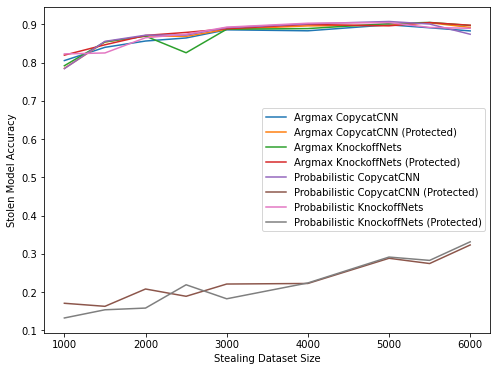

In [ ]:
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
groupby = df.groupby("Method Name")
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

# Cell 14
# Minimum and Maximum Accuracy Achieved

In [ ]:
df.sort_values(by=['Accuracy'],ascending=False)

,Method Name,Stealing Dataset Size,Accuracy
48,Probabilistic CopycatCNN,5000,0.907400
59,Argmax KnockoffNets,5500,0.904889
63,Argmax KnockoffNets (Protected),5500,0.904444
50,Probabilistic KnockoffNets,5000,0.904400
61,Argmax CopycatCNN (Protected),5500,0.904000
...,...,...,...
4,Probabilistic CopycatCNN (Protected),1000,0.170556
12,Probabilistic CopycatCNN (Protected),1500,0.162588
22,Probabilistic KnockoffNets (Protected),2000,0.158000
14,Probabilistic KnockoffNets (Protected),1500,0.153529


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Cell 15
# Comparing accuracy of probabilistic CopycatCNN and KnockoffNets, protected vs unprotected. Reverse sigmoid does not affect argmax version of both the attacks

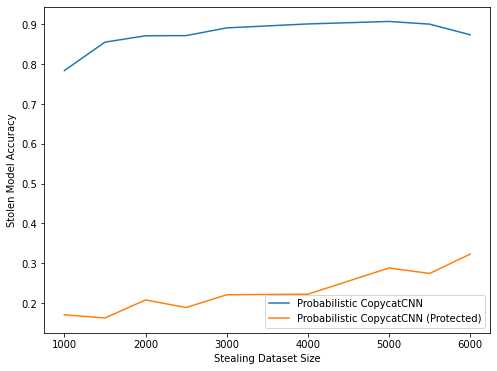

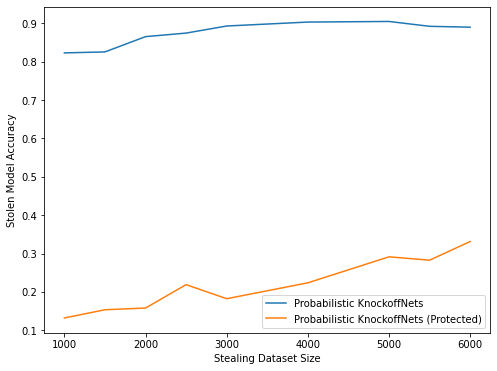

In [ ]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()

# Cell 16
# Performing the attack on victim model both protected and unprotected. Thief 2 is used here to perform extraction. It is a larger model than the victim.

In [ ]:
num_epochs = 10
#Victim model unprotected
classifier_CNN_original = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False) # Wrapping the victim model in Keras classifier provided by IBM Art.
#Victim model protected. Reverse sigmoid is used as a defense.
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2) # Preparing defense. Beta is a psotive magnitude parameter and gamma is a convergence parameter. Refer to https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/postprocessor.html
classifier_CNN_protected = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor) # Wrapping the protected victim model in Keras classifier provided by IBM Art.

#Size of dataset for stealing
len_steal = 5000


attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                     "Probabilistic CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False)
                   }

results = []
for len_steal in [250, 500, 1000, 2000, 3000, 5000, 6000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]
    for name, attack in attack_catalogue.items():
        model_stolen = get_thief2(num_classes=10, c1=32, c2=64, d1=128 , loss = keras.losses.categorical_crossentropy )
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

# Cell 17
# Accuracy of stolen model.

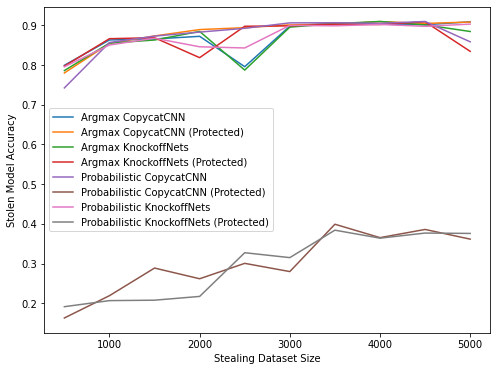

In [ ]:
df2 = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
groupby = df2.groupby("Method Name")
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df2.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

# Cell 18
# Minimum and MAximum Accuracy

In [ ]:
df2.sort_values(by=['Accuracy'],ascending=False)

,Method Name,Stealing Dataset Size,Accuracy
59,Argmax KnockoffNets,4000,0.909667
64,Probabilistic CopycatCNN,4500,0.909636
61,Argmax CopycatCNN (Protected),4000,0.909333
71,Argmax KnockoffNets (Protected),4500,0.908909
73,Argmax CopycatCNN,5000,0.908800
...,...,...,...
30,Probabilistic KnockoffNets (Protected),2000,0.217125
22,Probabilistic KnockoffNets (Protected),1500,0.207647
14,Probabilistic KnockoffNets (Protected),1000,0.206556
6,Probabilistic KnockoffNets (Protected),500,0.191263


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Run

# Cell 19
# Comparing accuracy of probabilistic CopycatCNN and KnockoffNets, protected vs unprotected. Reverse sigmoid does not affect argmax version of both the attacks

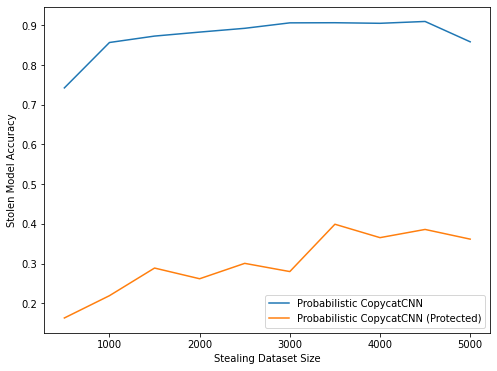

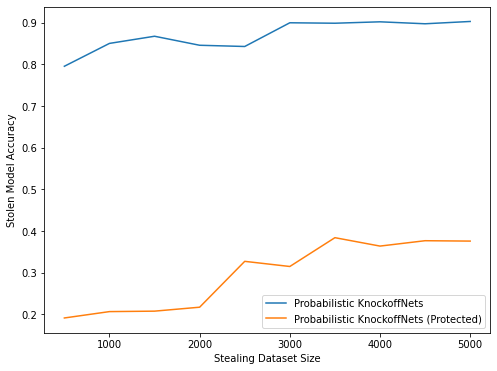

In [ ]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()

# Cell 20
# Performing attack with variable query size.

In [ ]:
num_epochs = 10
#Victim model unprotected
classifier_CNN_original = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False) # Wrapping the victim model in Keras classifier provided by IBM Art.
#Victim model protected. Reverse sigmoid is used as a defense.
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2) # Preparing defense. Beta is a psotive magnitude parameter and gamma is a convergence parameter. Refer to https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/postprocessor.html
classifier_CNN_protected = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor) # Wrapping the protected victim model in Keras classifier provided by IBM Art.

#Size of dataset for stealing
len_steal = 5000


results = []
for len_steal in [250, 500, 1000, 2000, 3000, 5000, 6000]:
    attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_CNN_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                     "Probabilistic CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False)
                   }
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]
    for name, attack in attack_catalogue.items():
        model_stolen = get_thief1(num_classes=10, c1=32,  d1=128 , loss = keras.losses.categorical_crossentropy )
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 2.2717 - accuracy: 0.1630
Epoch 2/10
1000/1000 [==============================] - 1s 519us/sample - loss: 2.2070 - accuracy: 0.2650
Epoch 3/10
1000/1000 [==============================] - 1s 518us/sample - loss: 2.1299 - accuracy: 0.3350
Epoch 4/10
1000/1000 [==============================] - 1s 511us/sample - loss: 2.0298 - accuracy: 0.4690
Epoch 5/10
1000/1000 [==============================] - 1s 514us/sample - loss: 1.9003 - accuracy: 0.5860
Epoch 6/10
1000/1000 [==============================] - 1s 530us/sample - loss: 1.7396 - accuracy: 0.6700
Epoch 7/10
1000/1000 [==============================] - 1s 515us/sample - loss: 1.5505 - accuracy: 0.7290
Epoch 8/10
1000/1000 [==============================] - 1s 514us/sample - loss: 1.3511 - accuracy: 0.7640
Epoch 9/10
1000/1000 [==============================] - 1s 523us/sample - loss: 1.1642 - accuracy: 0.7880
Epoch 10/10
1000/1000 [===

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN : 0.7922222
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 2.2551 - accuracy: 0.2630
Epoch 2/10
1000/1000 [==============================] - 1s 534us/sample - loss: 2.1735 - accuracy: 0.4280
Epoch 3/10
1000/1000 [==============================] - 1s 517us/sample - loss: 2.0744 - accuracy: 0.5390
Epoch 4/10
1000/1000 [==============================] - 1s 531us/sample - loss: 1.9440 - accuracy: 0.5880
Epoch 5/10
1000/1000 [==============================] - 1s 527us/sample - loss: 1.7783 - accuracy: 0.6430
Epoch 6/10
1000/1000 [==============================] - 1s 519us/sample - loss: 1.5822 - accuracy: 0.6900
Epoch 7/10
1000/1000 [==============================] - 1s 512us/sample - loss: 1.3783 - accuracy: 0.7160
Epoch 8/10
1000/1000 [==============================] - 1s 579us/sample - loss: 1.1857 - accuracy: 0.7400
Epoch 9/10
1000/1000 [==============================] - 1s 888us/sample - loss: 1.0237 - accura

# Cell 21
# Comparing accuracies.

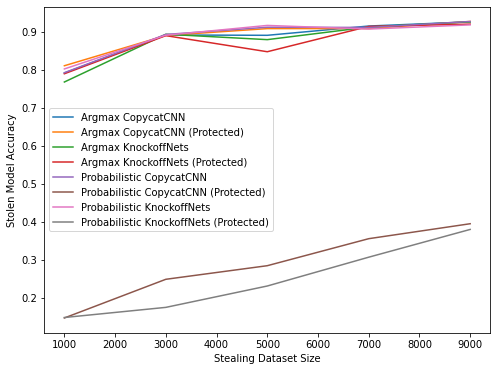

In [ ]:
df3 = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
groupby = df3.groupby("Method Name")
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df3.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

# Cell 22
# Minimum and Maximum accuracies.

In [ ]:
df3.sort_values(by=['Accuracy'],ascending=False)

,Method Name,Stealing Dataset Size,Accuracy
37,Argmax CopycatCNN (Protected),9000,0.927000
32,Probabilistic CopycatCNN,9000,0.927000
33,Argmax CopycatCNN,9000,0.926000
35,Argmax KnockoffNets,9000,0.926000
39,Argmax KnockoffNets (Protected),9000,0.920000
34,Probabilistic KnockoffNets,9000,0.918000
18,Probabilistic KnockoffNets,5000,0.916600
25,Argmax CopycatCNN,7000,0.915000
31,Argmax KnockoffNets (Protected),7000,0.914000
27,Argmax KnockoffNets,7000,0.912333


# Cell 23
# Gaussian noise defense

In [ ]:
from art.defences.postprocessor import GaussianNoise
postprocessor = GaussianNoise()
classifier_CNN_protected = KerasClassifier(model_CNN, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor) # Wrapping the protected victim model in Keras classifier provided by IBM Art.

#Size of dataset for stealing
len_steal = 5000


results = []
for len_steal in [250, 500, 1000, 2000, 3000, 5000, 6000]:
    attack_catalogue = {
                     "Probabilistic CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (Protected)": CopycatCNN(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (Protected)": KnockoffNets(classifier=classifier_CNN_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False)
                   }
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]
    for name, attack in attack_catalogue.items():
        model_stolen = get_thief1(num_classes=10, c1=32,  d1=128 , loss = keras.losses.categorical_crossentropy )
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        classifier_stolen = attack.extract(x_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 250 samples
Epoch 1/20
250/250 [==============================] - 0s 1ms/sample - loss: 2.3024 - accuracy: 0.0960
Epoch 2/20
250/250 [==============================] - 0s 883us/sample - loss: 2.2970 - accuracy: 0.1160
Epoch 3/20
250/250 [==============================] - 0s 806us/sample - loss: 2.2918 - accuracy: 0.1320
Epoch 4/20
250/250 [==============================] - 0s 827us/sample - loss: 2.2869 - accuracy: 0.1720
Epoch 5/20
250/250 [==============================] - 0s 807us/sample - loss: 2.2816 - accuracy: 0.1960
Epoch 6/20
250/250 [==============================] - 0s 788us/sample - loss: 2.2764 - accuracy: 0.2080
Epoch 7/20
250/250 [==============================] - 0s 803us/sample - loss: 2.2713 - accuracy: 0.2400
Epoch 8/20
250/250 [==============================] - 0s 790us/sample - loss: 2.2664 - accuracy: 0.2680
Epoch 9/20
250/250 [==============================] - 0s 818us/sample - loss: 2.2610 - accuracy: 0.2920
Epoch 10/20
250/250 [========================

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Probabilistic CopycatCNN (Protected) : 0.49210256
Train on 250 samples
Epoch 1/20
250/250 [==============================] - 0s 762us/sample - loss: 2.2898 - accuracy: 0.0920
Epoch 2/20
250/250 [==============================] - 0s 463us/sample - loss: 2.2732 - accuracy: 0.2120
Epoch 3/20
250/250 [==============================] - 0s 509us/sample - loss: 2.2563 - accuracy: 0.2800
Epoch 4/20
250/250 [==============================] - 0s 510us/sample - loss: 2.2402 - accuracy: 0.3240
Epoch 5/20
250/250 [==============================] - 0s 492us/sample - loss: 2.2237 - accuracy: 0.3640
Epoch 6/20
250/250 [==============================] - 0s 451us/sample - loss: 2.2072 - accuracy: 0.3960
Epoch 7/20
250/250 [==============================] - 0s 458us/sample - loss: 2.1904 - accuracy: 0.4400
Epoch 8/20
250/250 [==============================] - 0s 463us/sample - loss: 2.1720 - accuracy: 0.4760
Epoch 9/20
250/250 [==============================] - 0s 470us/sample - loss: 2.1537 - accuracy: 

# Cell 24
# Stolen model's accuracy.

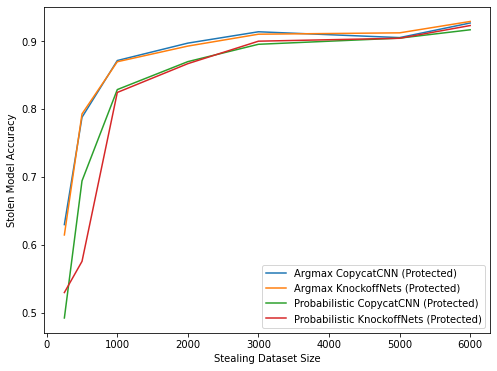

In [ ]:
df4 = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
groupby = df4.groupby("Method Name")
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df4.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()